# Figure S5 Mouse Fixation Data


Animals that started on DMS2:
| animal_id | sex | species | genotype | arrival_date | on_citric | training_start | off_citric |
|:------------:|:---------:|:----------:|:-----------:|:---------------:|:------------:|:-----------------:|:-------------:|
| R512 | male | mouse | cast_het | 4/24/23 | 6/30/23 | 7/12/23 | 7/18/23 |
| R513 | male | mouse | cast_het | 4/24/23 | 6/30/23 | 7/12/23 | 7/18/23 |
| R621 | female | mouse | cast_het | 4/25/23 | 7/7/23 | 7/26/23 | |
| R622 | female | mouse | cast_wt | 4/25/23 | 7/7/23 | 7/26/23 | |
| R623 | female | mouse | cast_het | 4/25/23 | 7/7/23 | 7/26/23 | |


In [1]:

import seaborn as sns
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import config as c
import utils as u

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

# 0. Load


In [2]:
tdf = pd.read_parquet("data/MouseFixation_tdf.parquet")

# Days to Fixation Target

## Cleaning

We need to clean up the data because animals would switch into the cpoke stages within a spoke stage (rather than overnight). This would happen late in the session and they wouldn't do a full session where they were only in the cpoke stage and therefore have a valid readout for growth.

Looking at the session table to cross validate the animals this happened with:

- R621 on 2023-08-22
- R513 on 2023-07-30
- R623 on 2023-08-25 started cpoke growth stage early in session but growth wasn't implemented overnight

Then need to filter for only the fixation growth stages (5-7), get the session level fixation summary for required (fixation_dur) and behaved (cpoke_dur) fixation info. We will then use this info to calculate the number of days to reach a common target. The target it 1.45 seconds because this appears to be the metric I used with the DMS animals (rats and mice) and will make a nice comparison to the Sound Discrimination Rat figure.


In [3]:
g_tdf = tdf.query("stage in @c.GROWING_STAGES").copy()
drop_pairs = [
    ("R621", pd.Timestamp("2023-08-22")),
    ("R513", pd.Timestamp("2023-07-30")),
]

mask = ~g_tdf.apply(
    lambda row: (row['animal_id'], row['dt_date']) in drop_pairs,
    axis=1
)

# apply
g_tdf = g_tdf.loc[mask].copy()

g_tdf = u.compute_days_relative_to_stage(g_tdf, stage=5) # recompute days relative to stage 5 after dropping the multi-stage days

g_tdf.loc[
    g_tdf['animal_id'] == 'R623',
    'days_relative_to_stage_5'
] = g_tdf.loc[
    g_tdf['animal_id'] == 'R623',
    'days_relative_to_stage_5'
] - 1

g_tdf = g_tdf.query("days_relative_to_stage_5 >= 0")


fix_val_df = (
    g_tdf
    .groupby(['animal_id', 'dt_date', 'days_relative_to_stage_5']).agg({'fixation_dur':'max', 'cpoke_dur':'mean'})
    .reset_index()
)

fix_val_df.head()


,animal_id,dt_date,days_relative_to_stage_5,fixation_dur,cpoke_dur
0,R512,2023-07-31,0,0.405,0.588034
1,R512,2023-08-01,1,0.605,0.813345
2,R512,2023-08-02,2,0.815,0.992047
3,R512,2023-08-03,3,1.005,1.194154
4,R512,2023-08-04,4,1.205,1.392138


## Compute Days to Target


In [4]:
# 1. Compute the threshold “day” for each animal
THRESHOLD = 1.1
thresholds = (
    fix_val_df
    .loc[fix_val_df['fixation_dur'] >= THRESHOLD]
    .groupby('animal_id')['days_relative_to_stage_5']
    .min()
)
thresholds_dict = thresholds.to_dict() # for vertical line plotting

# 2. Map that back onto your main frame
fix_val_df['threshold_day'] = fix_val_df['animal_id'].map(thresholds)

# 3. Keep only the rows up to threshold_day
fix_target_df = fix_val_df[
    fix_val_df['days_relative_to_stage_5'] <= fix_val_df['threshold_day']
].copy()

# 4. Count how many unique days it took to hit threshold
days_to_target = (
    fix_target_df
    .groupby('animal_id')['days_relative_to_stage_5']
    .nunique()
    .reset_index(name='n_days_fix_target')
)

days_to_target

,animal_id,n_days_fix_target
0,R512,5
1,R513,5
2,R621,3
3,R622,4
4,R623,5


## Fixation Growth Over Days


In [5]:
fix_val_df.head()

,animal_id,dt_date,days_relative_to_stage_5,fixation_dur,cpoke_dur,threshold_day
0,R512,2023-07-31,0,0.405,0.588034,4
1,R512,2023-08-01,1,0.605,0.813345,4
2,R512,2023-08-02,2,0.815,0.992047,4
3,R512,2023-08-03,3,1.005,1.194154,4
4,R512,2023-08-04,4,1.205,1.392138,4


[Text(0.5, 0, 'Days in Fixation Growth Curriculum'),
 Text(0, 0.5, 'Fixation Duration (s)'),
 (0.0, 1.5)]

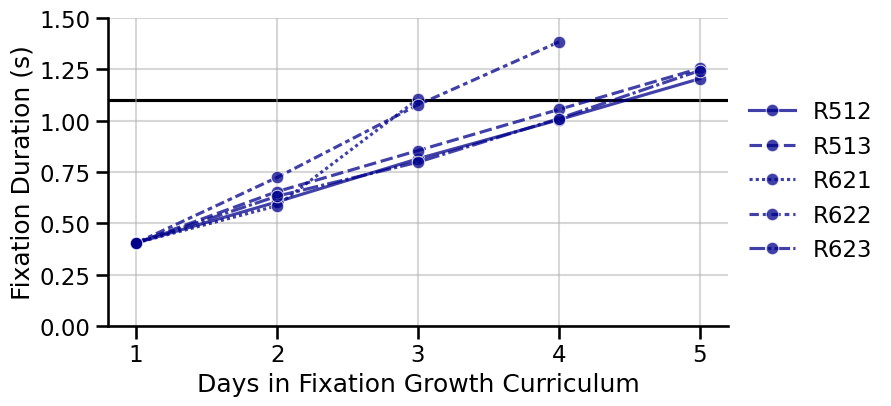

In [ ]:

fig, ax = plt.subplots(figsize=(8, 4))
sns.despine(ax=ax)

fix_target_df["days_relative_to_stage_5_adj"] = fix_target_df["days_relative_to_stage_5"] + 1

ax.axhline(THRESHOLD, color="black", zorder=0)
sns.lineplot(
    data=fix_target_df,
    x="days_relative_to_stage_5_adj",
    y="fixation_dur",
    style="animal_id",
    color=c.MOUSE_COLOR,
    marker="o",
    estimator="max",
    alpha=0.75,
)

#set x ticks to be 1-5
ax.set_xticks([1, 2, 3, 4, 5])
ax.legend(frameon=False, bbox_to_anchor=(1.0,.8))
ax.grid(alpha=0.5)

ax.set(xlabel="Days in Fixation Growth Curriculum", ylabel="Fixation Duration (s)", ylim=(0, 1.5))

c.save_fig(fig, "fig6_mouse_fixation_growth_over_days")

## Days to Target Summary


,index,n_days_fix_target
0,median,5.000000
1,mean,4.400000
2,std,0.894427
3,size,5.000000
4,min,3.000000
5,max,5.000000


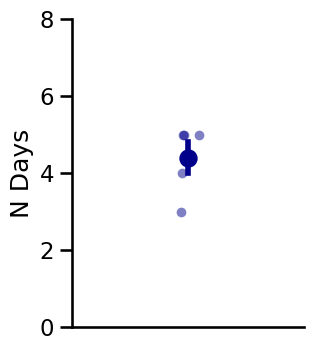

In [68]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.despine(ax=ax)
sns.pointplot(data=days_to_target, y="n_days_fix_target", color=c.MOUSE_COLOR, ax=ax,zorder=10, errorbar="se")
sns.stripplot(data=days_to_target, y="n_days_fix_target", color=c.MOUSE_COLOR, ax=ax, alpha=0.5, jitter=0.05, s=7)
ax.set(xlabel="", ylabel="N Days", ylim=(0,8))
ax.set(xticks=[])

stats = days_to_target['n_days_fix_target'].agg(['median', 'mean', 'std', 'size', 'min', 'max']).reset_index()


c.save_fig(fig, "fig6_mouse_fixation_n_days_to_target_summary.png")
stats

## Session to Session Growth Delta


In [16]:
# 1. Map threshold_day onto g_tdf
g_tdf['threshold_day'] = g_tdf['animal_id'].map(thresholds_dict)


# 2. Filter so that days_relative_to_stage_5 <= threshold_day (per animal)
g_tdf_filtered = g_tdf[
    g_tdf['days_relative_to_stage_5'] <= g_tdf['threshold_day']
].copy()
g_tdf_filtered["fix_experiment"] = "mice"
fixation_growth_df = u.make_fixation_growth_df(g_tdf_filtered)

In [18]:
stats = fixation_growth_df.groupby('fix_experiment')['fixation_growth'].agg(['median', 'mean', 'std', 'size'])
stats

,median,mean,std,size
fix_experiment,,,,
mice,0.21,0.245258,0.087583,22


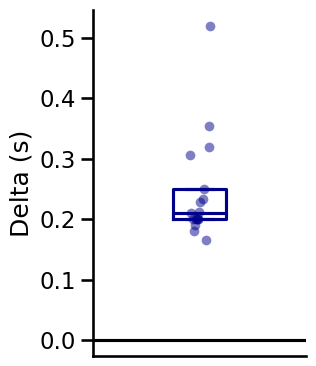

In [19]:
fig, ax = plt.subplots(figsize=(3.5,4))

sns.despine(ax=ax)
sns.boxplot(data=fixation_growth_df, y="fixation_growth", color=c.MOUSE_COLOR, ax=ax,zorder=10, fill=False, whis=0, width=0.25, showfliers=False)
sns.stripplot(data=fixation_growth_df, y="fixation_growth", color=c.MOUSE_COLOR, ax=ax, alpha=0.5, jitter=0.05, s=7)
ax.set(xlabel="", ylabel="Delta (s)")
ax.set(xticks=[])



ax.axhline(0, color="black", zorder=0)
plt.tight_layout()

c.save_fig(fig, "fig6_mouse_fixation_growth_delta_summary")


## Supplement- Plot Fixation Growth For Each Animal


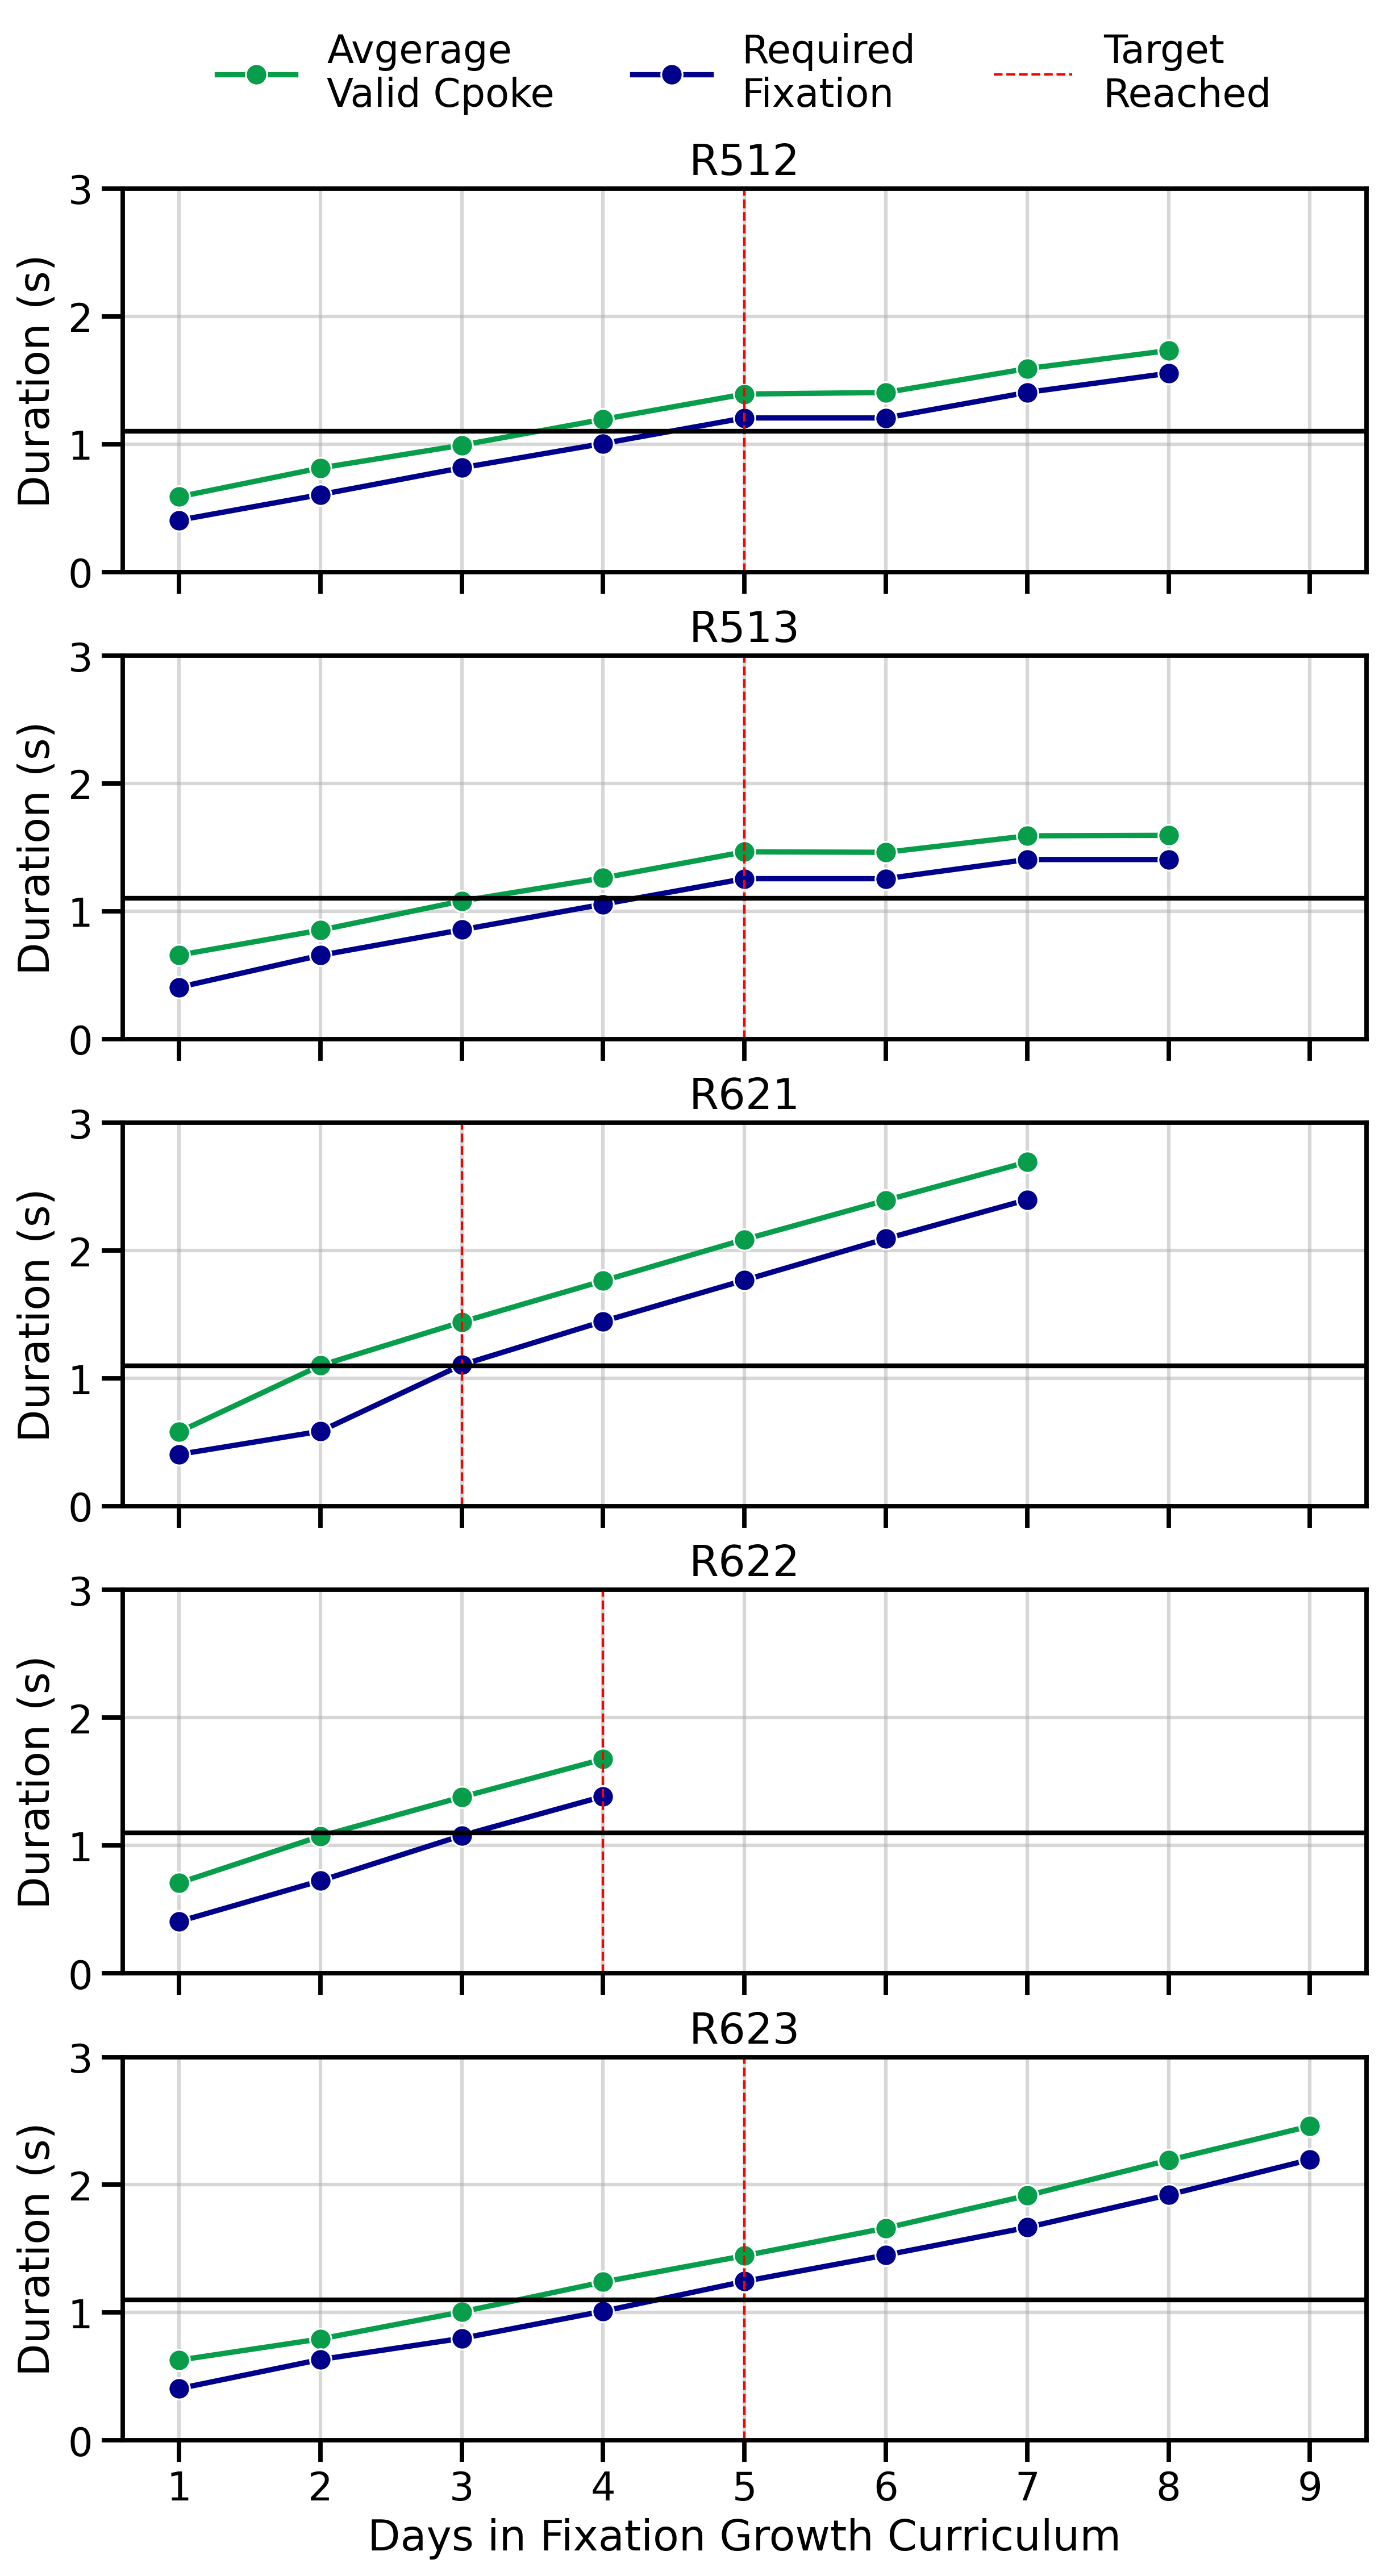

In [103]:
# group data
fix_val_df["days_relative_to_stage_5_adj"] = fix_val_df["days_relative_to_stage_5"] + 1
animal_groups = list(fix_val_df.groupby("animal_id"))
n_animals = len(animal_groups)

# 1. create a single‐column grid, share x and share y
fig, axes = plt.subplots(
    n_animals, 1,
    figsize=(8, 3 * n_animals),
    sharex=True, sharey=True,
    constrained_layout=True,
    dpi=300
)
if n_animals == 1:
    axes = [axes]

# 2. loop over each animal
for idx, (ax, (animal_id, sub_df)) in enumerate(zip(axes, animal_groups)):
    # plot cpoke_dur
    sns.lineplot(
        data=sub_df,
        x="days_relative_to_stage_5_adj",
        y="cpoke_dur",
        marker="o",
        color=c.VALID_COLOR,
        label="Avgerage\nValid Cpoke",
        ax=ax,
        errorbar=None,
    )
    # plot fixation_dur
    sns.lineplot(
        data=sub_df,
        x="days_relative_to_stage_5_adj",
        y="fixation_dur",
        marker="o",
        color=c.MOUSE_COLOR,
        label="Required\nFixation",
        ax=ax,
        errorbar=None,
    )

    # title and axes
    ax.set_title(animal_id)
    ax.grid(alpha=0.5)
    ax.set_ylim(0, 3)
    ax.set_ylabel("Duration (s)")

    # vertical line at threshold day
    thresh = thresholds_dict.get(animal_id)
    if pd.notnull(thresh):
        ax.axvline(thresh + 1, color='red', linestyle='--', linewidth=1, label=f"Target\nReached")

    # horizontal line at 1.45 s
    ax.axhline(THRESHOLD, color='k', linewidth=2)

    # legend only on first subplot
    if idx == 0:
        ax.legend(frameon=False, bbox_to_anchor=(0.5, 1.5), loc="upper center", ncol=3)
    else:
        ax.get_legend().remove()

# 3. common x‐label
axes[-1].set_xlabel("Days in Fixation Growth Curriculum")

c.save_fig(fig, "fig_S4_mouse_fixation_growth_over_days_raw")

# Violation Rates

## Cleaning

First thing we need to do is clean up the data. The previous session logic allowed for animals to move into the penalty on stage (stage 8) within a session, whereas the standard is an overnight switch. This led to three animals having 3 to 16 trials of stage 8 at the end of a session, we are going to remove those and count the first day in this stage as the first day where the session starts like that.


In [81]:
tdf = u.compute_days_relative_to_stage(tdf, stage=8)
v_tdf = tdf.query("days_relative_to_stage_8 > -5 and stage <=8").copy()

In [82]:
v_tdf.groupby(["animal_id", "dt_date"]).filter(lambda x: x['stage'].nunique() > 1).groupby(["animal_id", "dt_date", "stage"]).size().reset_index(name='num_trials')

,animal_id,dt_date,stage,num_trials
0,R621,2023-08-25,5.0,101
1,R621,2023-08-25,6.0,61
2,R621,2023-08-26,6.0,121
3,R621,2023-08-26,7.0,39
4,R621,2023-08-29,7.0,121
5,R621,2023-08-29,8.0,3
6,R622,2023-08-23,5.0,101
7,R622,2023-08-23,6.0,32
8,R622,2023-08-24,6.0,121
9,R622,2023-08-24,7.0,5


In [83]:
# 1. figure out which rows sit on a multi‐stage day
multi_stage = v_tdf.groupby(['animal_id','dt_date'])['stage'] \
                      .transform('nunique') > 1

# 2. drop only the stage 8 rows where multi_stage is True
v_tdf = v_tdf.loc[~(multi_stage & v_tdf['stage'].eq(8.0))].copy()
v_tdf = u.compute_days_relative_to_stage(v_tdf, stage=8) # need to recompute days relative to stage 8 after dropping the multi-stage days

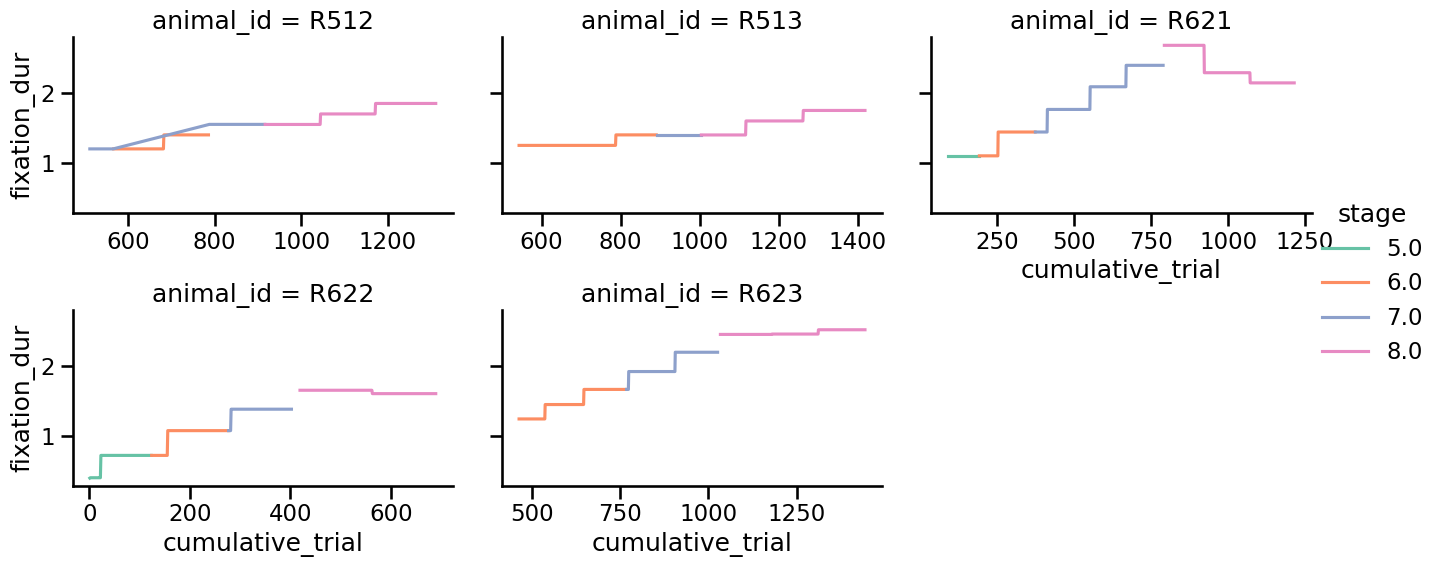

In [84]:
g = sns.relplot(
    data=v_tdf,
    x='cumulative_trial',            # our datetime axis
    y='fixation_dur',        # the value we want to plot
    kind='line',         # line plot
    col='animal_id',     # one facet per animal
    hue="stage",
    col_wrap=3,          # max 3 columns → rows are added as needed
    facet_kws={'sharey': True, 'sharex': False},         # show points
    height=3,            # height of each facet
    aspect=1.5,          # width = 1.5 × height
    palette="Set2"
)


## Compute Violation Rates

In the DMS2 protocol, violations weren't tracked unless the penalty was on (ie in stages 5-7) But, we have the number of attempted pokes (ie failed settling ins) for each trial and can unravel this to compute violation rates and then merge it back into the penalty on data (stage 8) to have a violation measure throughout.


In [85]:
def compute_violation_rate_df(df: pd.DataFrame) -> pd.DataFrame:
    # Group by date and apply the existing function
    grouped_results = df.groupby(
        ["animal_id", "date", "stage"], observed=False
    ).apply(compute_violation_rate)

    # Reset index to flatten the multi-index created by groupby
    failed_fix_df = grouped_results.reset_index(drop=True)

    return failed_fix_df

def compute_violation_rate(df: pd.DataFrame) -> pd.DataFrame:

    # determine penalty type- if settling in determines fix,
    # violation penalty is off. If not, violation penalty is on
    if df.stage.max() == 8:
        settling_in_determines_fix = False
    else:
        settling_in_determines_fix = True

    if settling_in_determines_fix:
        return compute_violation_rate_penalty_off(df)
    else:
        return compute_violation_rate_penalty_on(df)
    
def compute_violation_rate_penalty_off(group: pd.DataFrame) -> pd.DataFrame:
    # if there were no failed settling periods
    if (group["n_settling_ins"] > 1).sum() == 0:
        failed_fix_rate_by_poke = 0
    else:
        failed_fix_rate_by_poke = 1 - (len(group) / group["n_settling_ins"].sum())
    return pd.DataFrame(
        {
            "animal_id": [group.animal_id.iloc[0]],
            "stage": [group.stage.iloc[0]],
            "fixation_dur": [group.fixation_dur.max()],
            "date": [group.date.iloc[0]],
            "penalty": ["off"],
            "violation_rate": [failed_fix_rate_by_poke * 100],
        }
    )

def compute_violation_rate_penalty_on(group: pd.DataFrame) -> pd.DataFrame:

    # take the violation rate for the date
    return pd.DataFrame(
        {
            "animal_id": [group.animal_id.iloc[0]],
            "stage": [group.stage.iloc[0]],
            "fixation_dur": [group.fixation_dur.max()],
            "date": [group.date.iloc[0]],
            "penalty": ["on"],
            "violation_rate": [group.violations.mean() * 100],
        }
    )

In [86]:
viol_by_session_df = compute_violation_rate_df(v_tdf)

session_days = (
    v_tdf[["animal_id", "date", "days_relative_to_stage_8"]]
    .drop_duplicates(subset=["animal_id", "date"])
)

viol_by_session_df = (
    viol_by_session_df
    .merge(session_days, on=["animal_id", "date"], how="left")
)

viol_by_session_df.head()

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_8655/1552304305.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(compute_violation_rate)


,animal_id,stage,fixation_dur,date,penalty,violation_rate,days_relative_to_stage_8
0,R512,7.0,1.205,2023-08-04,off,56.000000,-4
1,R512,6.0,1.205,2023-08-13,off,43.137255,-3
2,R512,6.0,1.405,2023-08-14,off,46.938776,-2
3,R512,7.0,1.555,2023-08-15,off,44.680851,-1
4,R512,8.0,1.554,2023-08-16,on,25.781250,0


## Violation Rate Over Test Days


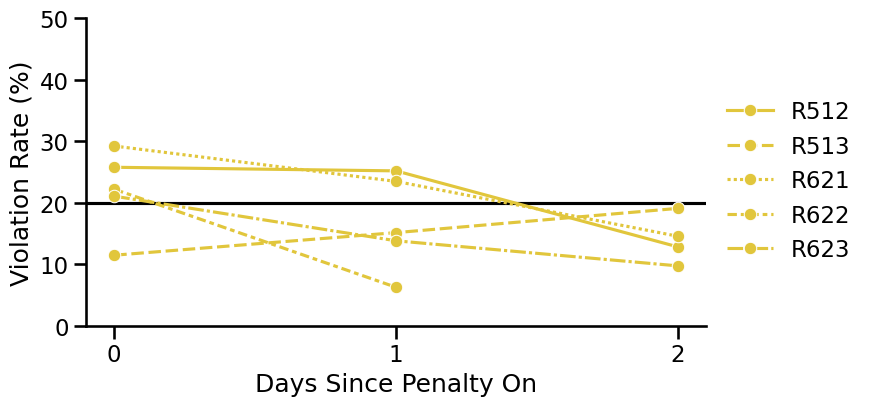

In [149]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.despine(ax=ax)
viol_penalty_on_over_days = viol_by_session_df.query("days_relative_to_stage_8 >=0").copy()
ax.axhline(20, color="black", zorder=0)
sns.lineplot(
    data=viol_penalty_on_over_days,
    x="days_relative_to_stage_8",
    y="violation_rate",
    style="animal_id",
    color=c.VIOLATION_COLOR,
    marker="o",
    estimator="max",
)

# x ticks are at 0, 1, 2
ax.set_xticks([0, 1, 2])
ax.legend(frameon=False, bbox_to_anchor=(1.0, .8))

_ = ax.set(xlabel="Days Since Penalty On", ylabel="Violation Rate (%)", ylim=(0, 50))

c.save_fig(fig, "fig6_mouse_violation_rate_over_days_penalty_on")


## Days in Violation Test


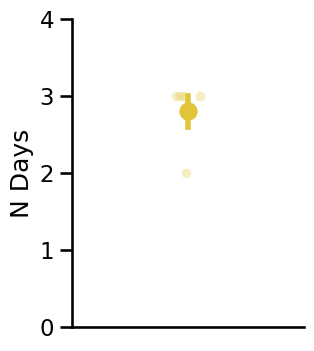

In [156]:
viol_penalty_on_over_days["days_relative_to_stage_8_adj"] = viol_penalty_on_over_days["days_relative_to_stage_8"] + 1
days_in_test_df  = viol_penalty_on_over_days.groupby("animal_id").days_relative_to_stage_8_adj.max().reset_index().rename(columns={"days_relative_to_stage_8_adj": "days_in_test"})


fig, ax = plt.subplots(figsize=(3, 4))
sns.despine(ax=ax)

sns.pointplot(data=days_in_test_df, y="days_in_test", color=c.VIOLATION_COLOR, ax=ax, zorder=10, errorbar="se")
sns.stripplot(data=days_in_test_df, y="days_in_test", color=c.VIOLATION_COLOR, ax=ax, alpha=0.3, jitter=0.07, s=7)

ax.set(xlabel="", ylabel="N Days", ylim= (0, 4))

#remove x ticks
ax.set_xticks([])

c.save_fig(fig, "fig6_mouse_days_in_violation_test")


In [131]:
stats = days_in_test_df.days_in_test.agg(['mean', 'std', 'min', 'max', 'median']).reset_index()
stats

,index,days_in_test
0,mean,2.800000
1,std,0.447214
2,min,2.000000
3,max,3.000000
4,median,3.000000


,index,pct_viol
0,median,17.140347
1,mean,17.868204
2,std,6.833716
3,size,14.000000


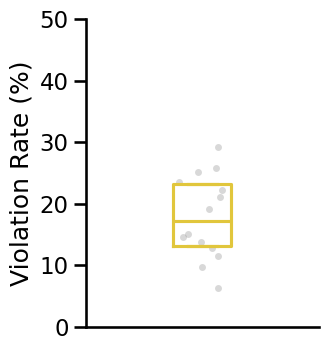

In [142]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.despine(ax=ax)

viol_session_df = v_tdf.query("stage == 8").groupby(['animal_id', 'dt_date']).agg({'violations':'mean'}).reset_index()
viol_session_df["pct_viol"] = viol_session_df["violations"] * 100

sns.boxplot(data=viol_session_df, y="pct_viol", color=c.VIOLATION_COLOR, ax=ax, showfliers=False, width=0.25, fill=False, whis=0, zorder=10)
sns.stripplot(data=viol_session_df, y="pct_viol", ax=ax, alpha=0.3, color="gray")
ax.set(xlabel="", ylabel="Violation Rate (%)")
ax.set(xticks=[], ylim=(0, 50))

stats = viol_session_df['pct_viol'].agg(['median', 'mean', 'std', 'size']).reset_index()
stats



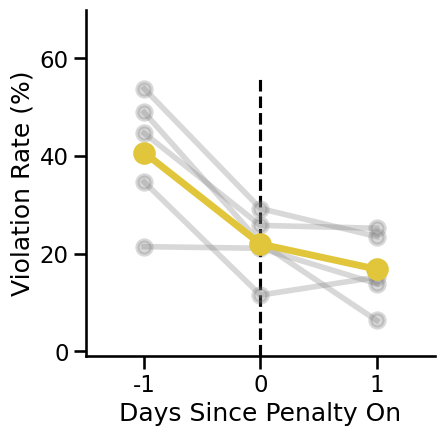

In [157]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
sns.despine()
day_range = [-1, 0, 1]

plot_df = viol_by_session_df.query("days_relative_to_stage_8 in @day_range")

ax.axvline(x=1, color="k", ls = "--", ymax=0.8   )
sns.pointplot(
    data=plot_df,
    x="days_relative_to_stage_8",
    y="violation_rate",
    hue="animal_id",
    palette=["gray"] * n_animals,
    ax=ax,
    alpha=0.3,
    legend=False
)
sns.pointplot(
    data=plot_df,
    x="days_relative_to_stage_8",
    y="violation_rate",
    color=c.VIOLATION_COLOR,
    ax=ax,
    errorbar=None,
    linewidth=5,  # make the line thicker
)


ax.set(
    ylabel="Violation Rate (%)",
    xlabel="Days Since Penalty On",
    ylim=(-1, 70),
)


c.save_fig(fig, "fig6_mouse_violation_rate_penalty_shift")


In [165]:
from scipy.stats import friedmanchisquare, wilcoxon
import itertools

df_wide = plot_df.pivot(index='animal_id', columns='days_relative_to_stage_8', values='violation_rate')

# Check the pivoted data (optional)
print(df_wide)

# Perform the Friedman test. Ensure you order the columns appropriately.
stat, p_value = friedmanchisquare(df_wide[-1], df_wide[0], df_wide[1])
print(f"Friedman test statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Define the days to compare and perform pairwise Wilcoxon tests
days = [-1, 0, 1]
comparisons = list(itertools.combinations(days, 2))
alpha = 0.05
alpha_adjusted = alpha / len(comparisons)  # Bonferroni correction

for d1, d2 in comparisons:
    stat, p = wilcoxon(df_wide[d1], df_wide[d2])
    print(f"Comparison between day {d1} and day {d2}: Wilcoxon statistic = {stat:.4f}, p-value = {p:.4f} (adjusted α = {alpha_adjusted:.4f})")

days_relative_to_stage_8         -1          0          1
animal_id                                                
R512                      44.680851  25.781250  25.196850
R513                      34.682081  11.504425  15.172414
R621                      53.816794  29.230769  23.489933
R622                      48.945148  22.222222   6.299213
R623                      21.428571  21.088435  13.846154
Friedman test statistic: 8.4000
P-value: 0.0150
Comparison between day -1 and day 0: Wilcoxon statistic = 0.0000, p-value = 0.0625 (adjusted α = 0.0167)
Comparison between day -1 and day 1: Wilcoxon statistic = 0.0000, p-value = 0.0625 (adjusted α = 0.0167)
Comparison between day 0 and day 1: Wilcoxon statistic = 2.0000, p-value = 0.1875 (adjusted α = 0.0167)


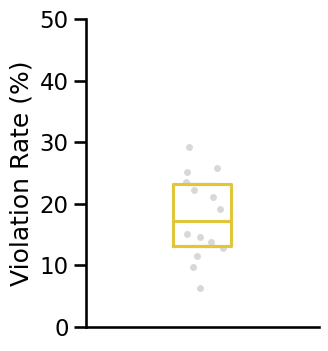

In [42]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.despine(ax=ax)

viol_session_df = v_tdf.query("stage == 8").groupby(['animal_id', 'dt_date']).agg({'violations':'mean'}).reset_index()
viol_session_df["pct_viol"] = viol_session_df["violations"] * 100

sns.boxplot(data=viol_session_df, y="pct_viol", color=c.VIOLATION_COLOR, ax=ax, showfliers=False, width=0.25, fill=False, whis=0, zorder=10)
sns.stripplot(data=viol_session_df, y="pct_viol", ax=ax, alpha=0.3, color="gray")
ax.set(xlabel="", ylabel="Violation Rate (%)")
ax.set(xticks=[], ylim=(0, 50))

stats = viol_session_df['pct_viol'].agg(['median', 'mean', 'std', 'size']).reset_index()
stats

c.save_fig(fig, "figS5_mouse_violation_rate_penalty_on_summary")


## Timeouts & ITI


In [ ]:
v_tdf.query("stage == 8").groupby(["animal_id", "violations"]).timeouts.mean().reset_index()

,animal_id,violations,timeouts
0,R512,0,0.1
1,R512,1,0.1
2,R513,0,0.1
3,R513,1,0.1
4,R621,0,0.1
5,R621,1,0.1
6,R622,0,0.1
7,R622,1,0.1
8,R623,0,0.1
9,R623,1,0.1


In [41]:
v_tdf.query("stage == 8").groupby(["animal_id", "violations"]).inter_trial_dur.mean().reset_index()

,animal_id,violations,inter_trial_dur
0,R512,0,2.019891
1,R512,1,2.069284
2,R513,0,2.003017
3,R513,1,2.045414
4,R621,0,2.025749
5,R621,1,2.009381
6,R622,0,2.035714
7,R622,1,1.889884
8,R623,0,1.989021
9,R623,1,2.011001


> Doesn't appear the animals had any violation timeout. Instead, they just had an ITI that was 2 seconds on average and no specific additional penalty for the violation. Suggests that there is potential to lower the violation rate by increasing this penalty


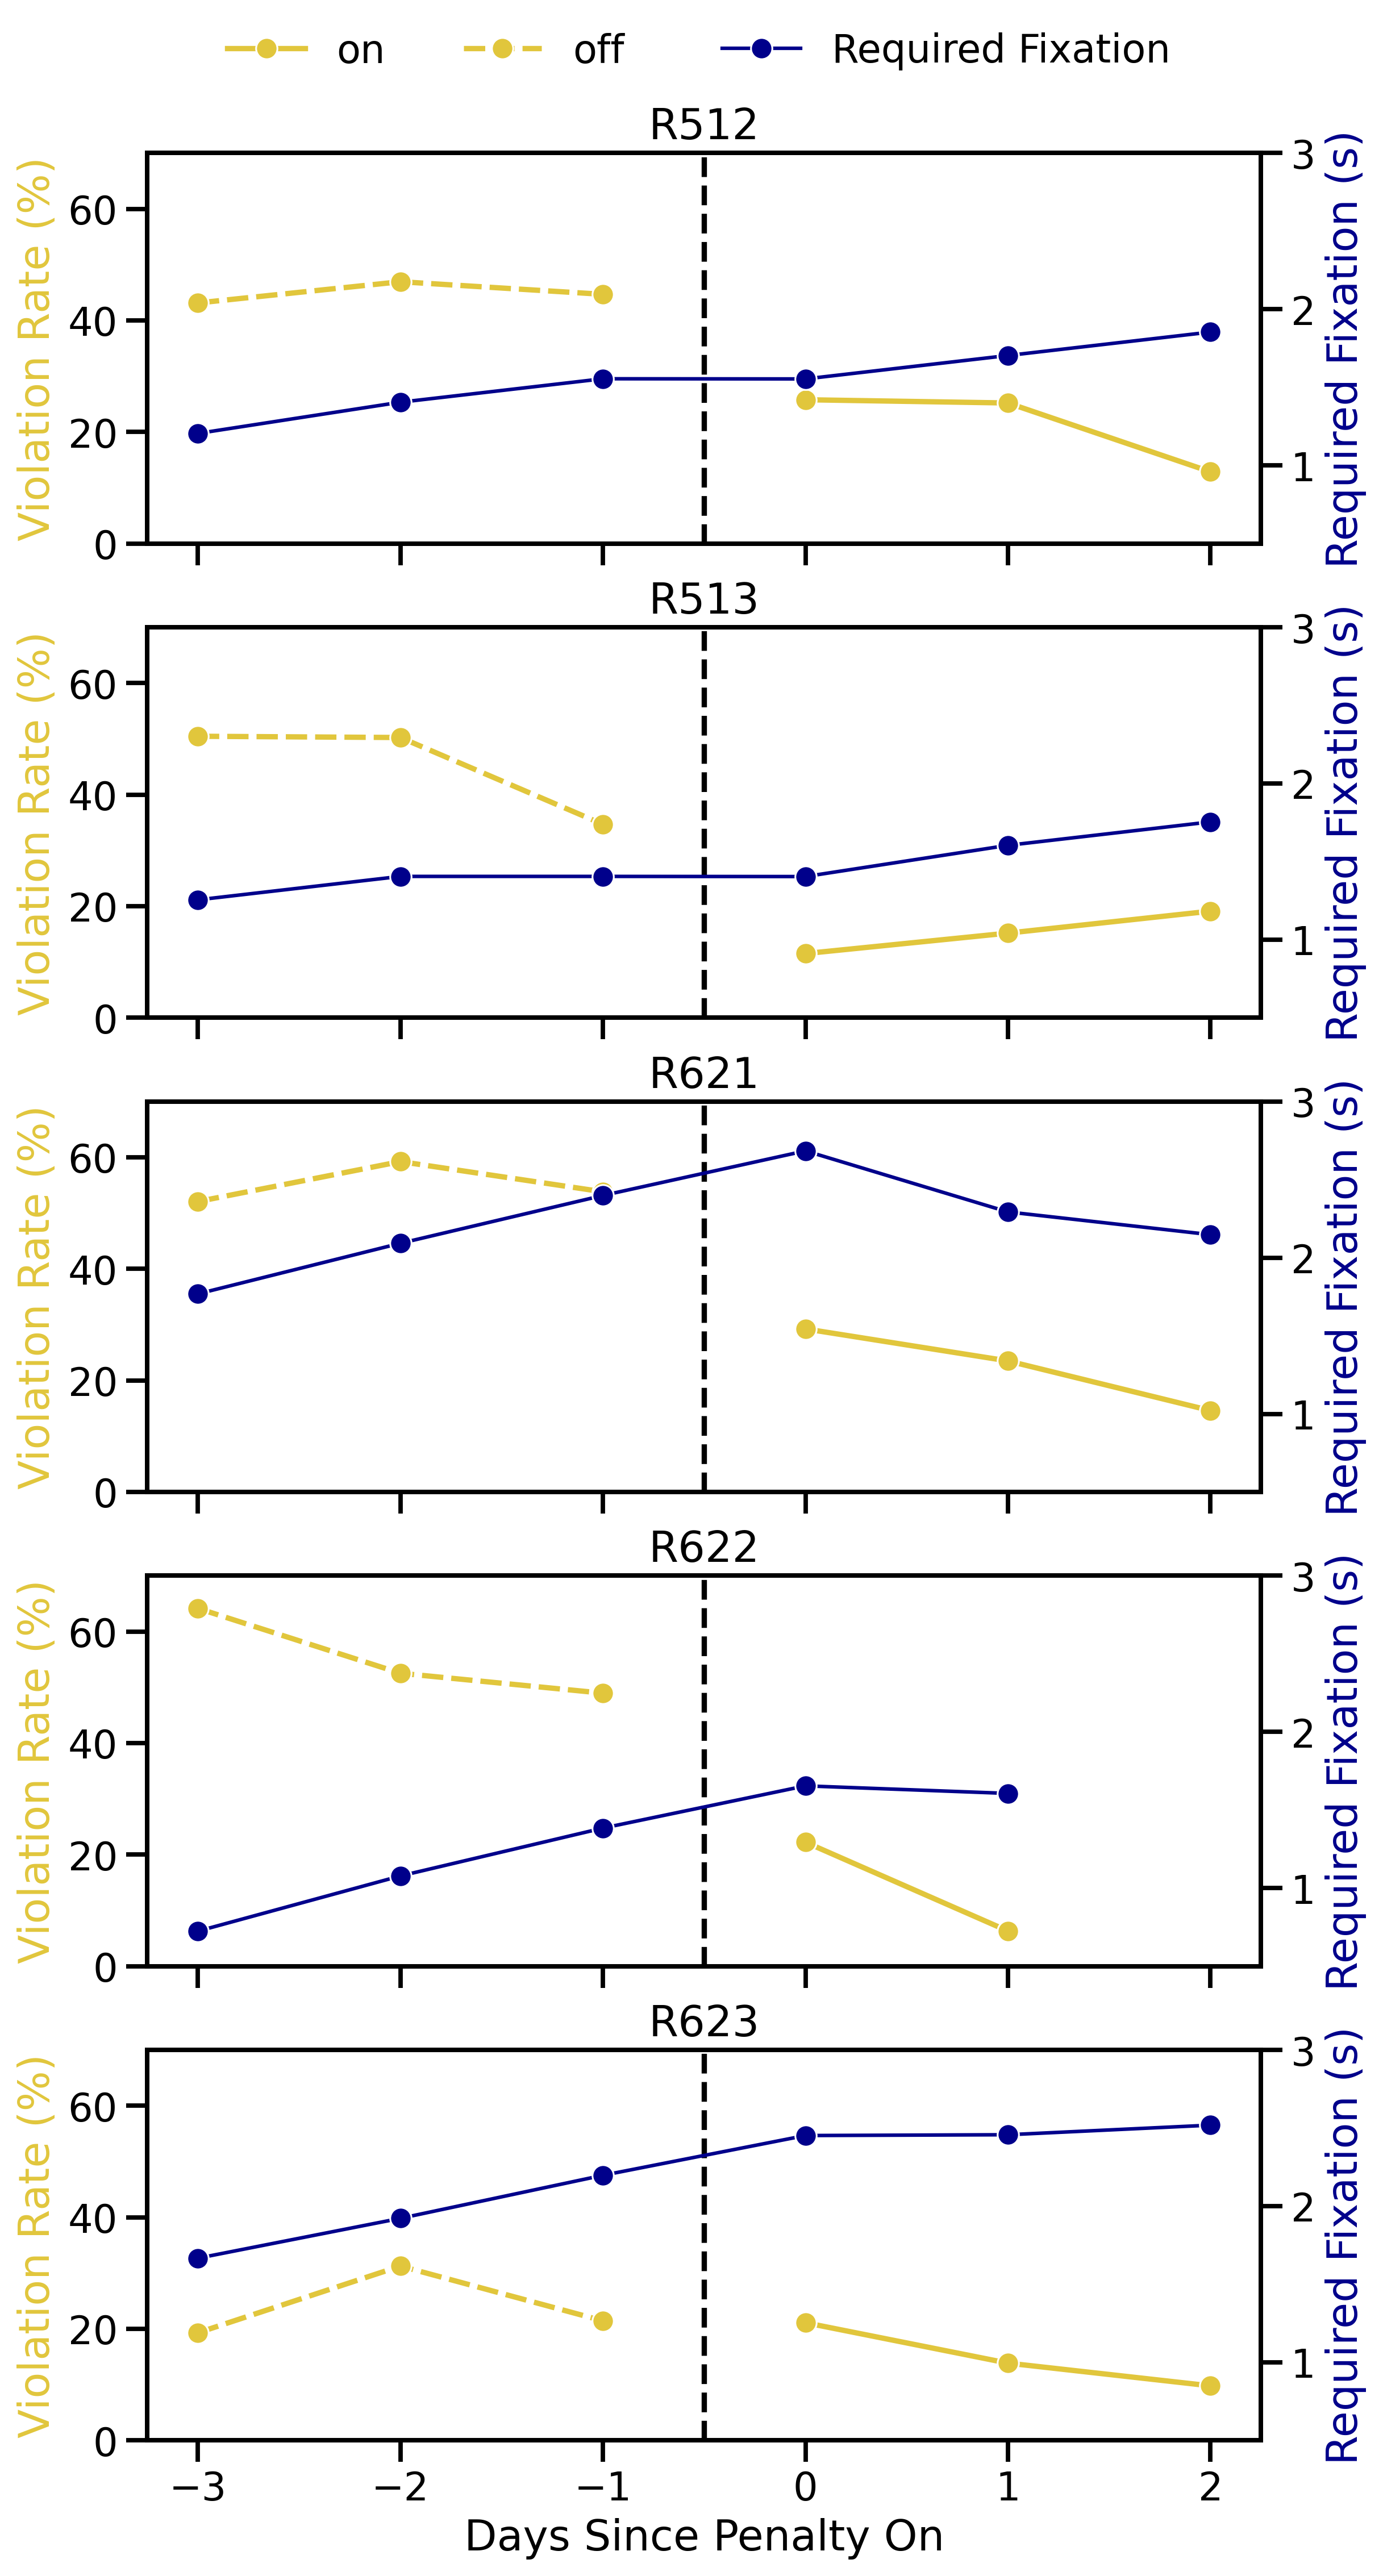

In [161]:
## Supplement- Plot Penalty On Effect For Each Animal

plot_df = viol_by_session_df.query("days_relative_to_stage_8 >= -3")
animal_groups = list(plot_df.groupby("animal_id"))
n_animals = plot_df["animal_id"].nunique()


# 1. create a single‐column grid, share x and share y
fig, axes = plt.subplots(
    n_animals, 1,
    figsize=(8, 3 * n_animals),
    sharex=True, sharey=True,
    constrained_layout=True,
    dpi=300
)

# 2. loop
for idx, (ax, (animal_id, sub_df)) in enumerate(zip(axes, animal_groups)):

    sns.lineplot(
        data=sub_df,
        x="days_relative_to_stage_8",
        y="violation_rate",
        marker="o",
        color=c.VIOLATION_COLOR,
        style="penalty",
        style_order=["on", "off"],
        ax=ax,
        errorbar=None,
    )

    ax.set_ylabel("Violation Rate (%)", color=c.VIOLATION_COLOR)
    ax.set_title(animal_id)
    ax.set_ylim(0, 70)

    # --- twin‐y for fixation duration ---
    twin = ax.twinx()

    sns.lineplot(
        data=sub_df,
        x="days_relative_to_stage_8",
        y="fixation_dur",
        color=c.MOUSE_COLOR,
        ax=twin,
        errorbar=None,
        linewidth=1.5,
        marker="o",
        label="Required Fixation"
    )
    twin.set_ylabel("Required Fixation (s)", color=c.MOUSE_COLOR)
    twin.yaxis.label.set_color(c.MOUSE_COLOR)
    twin.tick_params(axis="y")
    twin.set_ylim(0.5, 3)

    # turn off legend for all but the first axis
    # strip off extra legends
    # legend only on first subplot
    if idx == 0:
        ax.legend(frameon=False, bbox_to_anchor=(0.25, 1.4), loc="upper center", ncol=2)
        twin.legend(frameon=False, bbox_to_anchor=(0.95, 1.4), loc="upper right")
    else:
        ax.get_legend().remove()
        twin.get_legend().remove()
    ax.axvline(-0.5, color="k", ls="--")

# 3. common x‐label
axes[-1].set_xlabel("Days Since Penalty On")

c.save_fig(fig, "fig_S4_mouse_violation_rate_over_days_penalty_on_raw")
